<a href="https://colab.research.google.com/github/Sirfowahid/FFN/blob/master/FNN_BinMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [3]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

data = data[:,1:]
labels = data[:,0]

Text(0.5, 1.0, 'Histogram of normalized data')

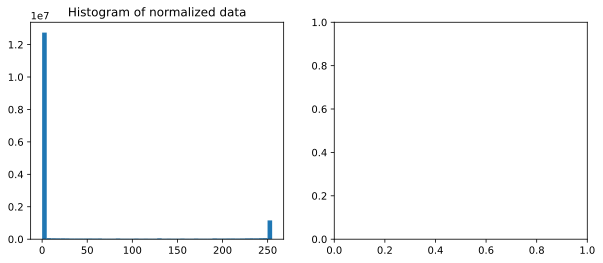

In [4]:
dataNorm = (data>0).astype(float)

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].hist(data.flatten(),50)
ax[0].set_title('Histogram of original data')

ax[0].hist(dataNorm.flatten(),50)
ax[0].set_title('Histogram of normalized data')


In [5]:
print(np.unique(data))
print('')
print(np.unique(dataNorm))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [6]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

train_data,test_data,train_labels,test_labels = train_test_split(dataT,labelsT,test_size=.1)

train_dataset = TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data,test_labels)

batchsize = 32
train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size=train_dataset.tensors[0].shape[0])

In [7]:
def createTheMNISTNet():

  class mnistnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784,64)

      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      self.output = nn.Linear(32,10)

    def forward(self,x):

      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return torch.log_softmax(self.output(x),axis=1)
  net = mnistnet()
  lossfun = nn.NLLLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)
  return net,lossfun,optimizer

In [8]:
net,lossfun,optimizer = createTheMNISTNet()

X,y = iter(train_loader).next()
yHat = net(X)

torch.unique(X)

tensor([0., 1.])

In [12]:
def func2trainTheModel():

  numepochs = 60

  net,lossfun,optimizer = createTheMNISTNet()

  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []

  for epochi in range(numepochs):

    batchLoss = []
    batchAcc = []

    for X,y in train_loader:
      yHat = net(X)

      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())
      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())

    trainAcc.append(np.mean(batchAcc))
    losses[epochi] = np.mean(batchLoss)

    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)

    testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
  
  return trainAcc,testAcc,losses,net



In [13]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()

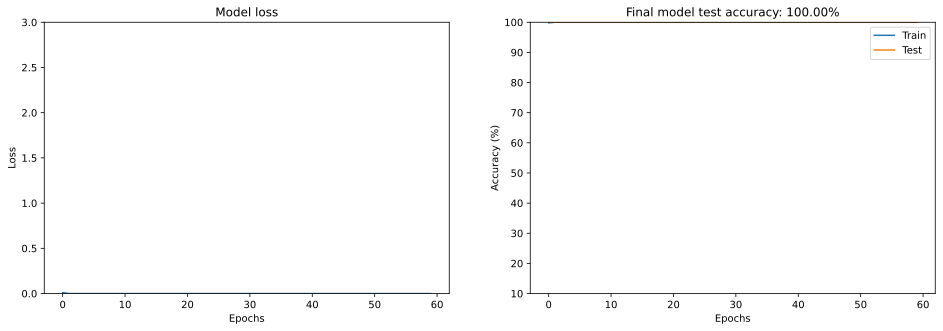

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()